<a href="https://colab.research.google.com/github/YMGYM/google_colab_files/blob/master/Beijing_air_plollution_2(final).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

이 파일은 황철현, 신강욱의
`미세먼지 예측 성능 개선을 위한 CNN-LSTM 결합 방법`
논문의 구현 연습 파일입니다.

데이터셋은 [Beijing PM2.5 데이터셋](https://www.kaggle.com/djhavera/beijing-pm25-data-data-set)
을 사용했습니다.

# Import All

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load Data

In [2]:
! unzip /content/drive/My\ Drive/Datasets/beijing_air.zip -d data

Archive:  /content/drive/My Drive/Datasets/beijing_air.zip
  inflating: data/PRSA_data_2010.1.1-2014.12.31.csv  


In [3]:
def get_data():
  all_data = pd.read_csv('/content/data/PRSA_data_2010.1.1-2014.12.31.csv') # 전체 데이터
  dropped_data = all_data.drop(['No', 'year', 'month', 'day', 'hour'],axis=1) # 필요 없는 데이터는 버림
  pm25 = dropped_data.pop('pm2.5') # 미세먼지 데이터 확인
  pm25 = pm25.fillna(method='pad')
  
  return pm25, dropped_data

# Make Normalize Dataset

In [4]:
class PmScaler():
  def __init__(self, pm25):
    self.scaler = MinMaxScaler()
    self.pm25 = pm25.fillna(1e-8, limit=1)
    self.pm25 = self.pm25.fillna(method="pad")
    
  def make_norlized_dataset(self, rate, x = None, data_len=2): 
    if x is None:
      x = self.pm25[data_len-1:]
    arrlen = int(len(x) * (rate) + 1)
    if isinstance(x, type(np.array([]))) == False:
      reshaped = x.to_numpy().reshape(-1,1)
    else:
      reshaped = x.reshape(-1,1)
    scaled_data = self.scaler.fit_transform(reshaped)

    train, val, test = scaled_data[:-1 * (arrlen * 2)], scaled_data[-1 * (arrlen * 2) : -1 * (arrlen)], scaled_data[-1 * (arrlen):]

    return train[1:], val[1:], test[1:]
  
  def invert_scale(self, x):
    inverse = self.scaler.inverse_transform(x)
    return inverse

In [5]:
class ProxyDataScaler():
  def __init__(self, data):
    self.table = data
    self.scaler = MinMaxScaler()
    
  def change_cbwd_data(self):
    mapping = {}
    cols = self.table["cbwd"].value_counts().index

    for i, col in enumerate(cols):
      mapping[col] = i # mapping = {"SE" : 0, "NW": 1, "cv": 2, "NE":3}
    self.table = self.table.replace({'cbwd' : mapping})
    print("cbwd data changed to number : {SE : 0, NW: 1, cv: 2, NE:3} ")

  def make_normalize_data(self):
    self.norm_data = self.scaler.fit_transform(self.table)
    return self.norm_data

  def slice_proxy_data(self, time):
    col_cnt = len(self.table.columns)
    if (self.norm_data is not None): # 정규화된 데이터가 있는지 확인
      print("norm_data detected")

      if isinstance(self.norm_data, type(np.array([]))) == False: # 데이터를 numpy 형식으로 변환
        data = self.norm_data.to_numpy().astype("float32")
      else:
        data = self.norm_data.astype("float32")

    else:
      print("norm_data not detected")
      data = self.table.to_numpy().astype("float32")

    self.sliced_data = np.zeros(shape=(1,time,col_cnt))

    for i in range((len(data)-time) + 1):
      if i == 0:
        self.sliced_data = data[:i+time].reshape(1, time,-1)
      else:
        self.sliced_data = np.vstack((self.sliced_data, data[i:i+time].reshape(1,time,-1)))
        
    return self.sliced_data

  def split_data(self, data = None, rate = 0.1):
    if data is None:
      arrlen = int(len(self.sliced_data) * (rate) + 1)
      data = self.sliced_data
    else:
      arrlen = int(len(data) * rate + 1)
      data = data

    train, val, test = data[:-1 * (arrlen * 2)], data[-1 * (arrlen * 2) : -1 * (arrlen)], data[-1 * (arrlen):]

    return train, val, test

# New LSTM Data generator

In [6]:
class LSTMInputGenerator(K.utils.Sequence):
  def __init__(self, lstm_x, lstm_y, data_len, cnn_output, batch_size=1):
    self.lstm_data_gen = K.preprocessing.sequence.TimeseriesGenerator(lstm_x, lstm_x, batch_size=batch_size, length=data_len, shuffle=False)
    self.cnn_output = cnn_output[data_len-1:]
    print(f"lstm_data_gen len : {self.lstm_data_gen.__len__()}, cnn_output len : {len(self.cnn_output)}")
    self.batch_size = batch_size
    
  def __getitem__(self, index):
    lstm_x, lstm_y = self.lstm_data_gen[index]
    stack_data = self.cnn_output[index*self.batch_size : (index + 1)*self.batch_size].reshape(-1,1,1)
    # print(f"index : {index} / lstm_x shape : {lstm_x.shape} / stack_data.shape: {stack_data.shape}")
    return_x = np.concatenate((lstm_x, stack_data),axis=1)
    return return_x, lstm_y
    
  def __len__(self):
    return self.lstm_data_gen.__len__()

# Entire Model

In [7]:
class EntireModel():
  def __init__(self, pm25, proxydata):
    # -----------scaler 클래스 생성 -------------------
    self.pm25 = pm25.fillna(1e-8, limit=1)
    self.pm25 = self.pm25.fillna(method="pad")
    print(f"pm25 length : {len(self.pm25)}" )
    self.proxydata = proxydata
    print(f"proxydata length : {len(self.proxydata)}" )
    self.pmScaler = PmScaler(pm25)
    self.proxyScaler = ProxyDataScaler(proxydata)
    
    # ---------- train 용 callbacks -----------
    self.lstm_callbacks = [K.callbacks.TensorBoard(log_dir='lstm_logs')]
    self.cnn_callbacks = [K.callbacks.TensorBoard(log_dir='cnn_logs')]

  def make_proxy_data_generator(self, data_len = 2):
    # ---------- proxy 데이터 전처리 -----------
    self.proxyScaler.change_cbwd_data() # 문자 데이터를 숫자 범주로
    norm_data = self.proxyScaler.make_normalize_data() # 데이터 정규화
    self.proxyScaler.slice_proxy_data(data_len) # 데이터 길이별로 자름
    print(f"sliced_data length : {len(self.proxyScaler.sliced_data)}// shape : {self.proxyScaler.sliced_data.shape} // data_len: {data_len}" )
    cnn_x_train, cnn_x_val, cnn_x_test = self.proxyScaler.split_data( rate = 0.1) # x 데이터 분할
    print(f"cnn_x_train : {len(cnn_x_train)}, {cnn_x_train.shape}, cnn_x_val : {len(cnn_x_val)}, cnn_x_test length: {len(cnn_x_test)}  // data_len: {data_len}" )
    self.grad_level = self._get_grad_pm25() # 미세먼지 변화량을 구함
    print(f"grad_level length : {len(self.grad_level)} // data_len: {data_len}" )
    cnn_y_train, cnn_y_val, cnn_y_test = self._cnn_y_split(self.grad_level, data_len) # y 데이터 분할
    print(f"cnn_y_train : {len(cnn_y_train)}, cnn_y_val : {len(cnn_y_val)}, cnn_x_test length: {len(cnn_y_test)}  // data_len: {data_len}" )
    # ---------- Data Generator 생성 ---------
    self.cnn_train_data_gen = K.preprocessing.sequence.TimeseriesGenerator(cnn_x_train, cnn_y_train, length=1, batch_size = 128, shuffle=False)
    self.cnn_val_data_gen = K.preprocessing.sequence.TimeseriesGenerator(cnn_x_val, cnn_y_val, length=1, batch_size = 128, shuffle=False)
    self.cnn_test_data_gen = K.preprocessing.sequence.TimeseriesGenerator(cnn_x_test, cnn_y_test, length=1, batch_size = 1, shuffle=False)
    print(f"cnn_train_data_gen length : {self.cnn_train_data_gen.__len__()} // data_len: {data_len}" )
    # ----------- 모델 생성 --------------
    print("Make CNN Model....")
    self.cnn_model = self._get_cnn_model(input_shape=(1, cnn_x_train.shape[1], cnn_x_train.shape[2]))

  def make_lstm_data_generator(self, data_len = 15, batch_size = 1):
    # ---------- pm25 데이터 전처리 -----------
    pm25_x_train, pm25_x_val, pm25_x_test = self.pmScaler.make_norlized_dataset(rate = 0.1)
    print(f"pm25_x_train length : {len(pm25_x_train)}" )
    print(f"pm25_x_val length : {len(pm25_x_val)}" )
    print(f"pm25_x_test length : {len(pm25_x_test)}" )
    self.pm25_test = pm25_x_test

    # ---------- pm25 Data Generator -------------
    self.pm25_train_data_gen = K.preprocessing.sequence.TimeseriesGenerator(pm25_x_train, pm25_x_train, batch_size=batch_size, length=1, shuffle=False)
    self.pm25_val_data_gen = K.preprocessing.sequence.TimeseriesGenerator(pm25_x_val, pm25_x_val, batch_size = batch_size, length=1, shuffle=False)
    self.pm25_test_data_gen = K.preprocessing.sequence.TimeseriesGenerator(pm25_x_test, pm25_x_test, batch_size = 1, length=1, shuffle=False)

    # ---------- CNN result ------------
    print("get CNN output..")
    print("-----------get train output ---------")
    self.cnn_train_output = self.cnn_model.predict(self.cnn_train_data_gen)
    print(f"cnn_train_output length : {len(self.cnn_train_output)}" )
    cnn_train_output_gen = K.preprocessing.sequence.TimeseriesGenerator(self.cnn_train_output, self.cnn_train_output, batch_size = batch_size, length=1, shuffle=False)
    rated_cnn_train_output = self._make_lstm_input(cnn_train_output_gen, self.pm25_train_data_gen)
    print(f"rated_cnn_train_output length : {len(rated_cnn_train_output)}" )

    print("-----------get validation output ---------")
    self.cnn_val_output = self.cnn_model.predict(self.cnn_val_data_gen)
    print(f"cnn_val_output length : {len(self.cnn_val_output)}" )
    cnn_val_output_gen = K.preprocessing.sequence.TimeseriesGenerator(self.cnn_val_output, self.cnn_val_output, batch_size = batch_size, length=1, shuffle=False)
    rated_cnn_val_output = self._make_lstm_input(cnn_val_output_gen, self.pm25_val_data_gen)
    print(f"rated_cnn_val_output length : {len(rated_cnn_val_output)}" )


    print("-----------get test output ---------")
    self.cnn_test_output = self.cnn_model.predict(self.cnn_test_data_gen)
    print(f"cnn_test_output length : {len(self.cnn_test_output)}" )
    cnn_test_output_gen = K.preprocessing.sequence.TimeseriesGenerator(self.cnn_test_output, self.cnn_test_output, batch_size = batch_size, length=1, shuffle=False)
    rated_cnn_test_output = self._make_lstm_input(cnn_test_output_gen, self.pm25_test_data_gen)

    # ---------- LSTM data gen ---------
    self.lstm_train_data_gen = LSTMInputGenerator(pm25_x_train, pm25_x_train, data_len, rated_cnn_train_output, batch_size = batch_size)
    self.lstm_val_data_gen = LSTMInputGenerator(pm25_x_val, pm25_x_val, data_len, rated_cnn_val_output, batch_size = batch_size)
    self.lstm_test_data_gen = LSTMInputGenerator(pm25_x_test, pm25_x_test, data_len, rated_cnn_test_output, batch_size = batch_size)

    # ---------- 모델 생성
    print("make LSTM model...")
    self.lstm_model = self._get_lstm_model(input_shape=(data_len + 1,1))

  def cnn_model_fit(self, epochs=1):
    self.cnn_model.fit(x=self.cnn_train_data_gen, epochs=epochs, validation_data=(self.cnn_val_data_gen), callbacks=self.cnn_callbacks)

  def lstm_model_fit(self, epochs=1):
    self.lstm_model.fit(x=self.lstm_train_data_gen, epochs=epochs, validation_data=self.lstm_val_data_gen, callbacks=self.lstm_callbacks)

  def total_model_evaluate(self):
    return self.lstm_model.evaluate(self.lstm_test_data_gen)

  def total_model_predict(self, data = None):
    if data is None:
      data = self.lstm_test_data_gen
    return self.lstm_model.predict(x=self.lstm_test_data_gen)

  def _get_cnn_model(self, input_shape):
    cnnModel = K.Sequential()
    cnnModel.add(K.layers.Conv2DTranspose(32, (2,2), input_shape=input_shape, activation="relu"))
    cnnModel.add(K.layers.MaxPool2D(strides=2))
    cnnModel.add(K.layers.Flatten())
    cnnModel.add(K.layers.Dropout(0.1))
    cnnModel.add(K.layers.Dense(100, activation="relu"))
    cnnModel.add(K.layers.ReLU())
    cnnModel.add(K.layers.Dense(5, activation="softmax"))
    cnnModel.summary()
    cnnModel.compile(optimizer="adam", loss="MSE")

    return cnnModel

  def _get_lstm_model(self, input_shape):
    lstm_model = K.Sequential()
    lstm_model.add(K.layers.LSTM(216, input_shape=input_shape))
    lstm_model.add(K.layers.Dropout(0.3))
    lstm_model.add(K.layers.Dense(128, activation="relu"))
    lstm_model.add(K.layers.Dropout(0.3))
    lstm_model.add(K.layers.Dense(1, activation="sigmoid"))
    lstm_model.summary()
    lstm_model.compile(optimizer="adam", loss="MSE")

    return lstm_model

  def _cnn_y_split(self, data, data_length, rate=0.1):
    # cnn에 입력할 Y 데이터를 나눔
    data = data[data_length-1:]
    data = K.utils.to_categorical(data)
    arrlen = int(len(data) * rate + 1)

    train, val, test =  data[:-1 * (arrlen * 2)], data[-1 * (arrlen * 2) : -1 * (arrlen)], data[-1 * (arrlen):]
    return train, val, test

  def _get_grad_pm25(self):
    # pm25 의 변화율을 구하고 범주화함
    grad_data = self.pm25.pct_change()
    grad_data = grad_data.fillna(method="pad")
    bins = [-9.166667e-02, -1e-15,1e-15, 1.212121e-01]
    grad_level = np.digitize(grad_data, bins=bins, right=False)
    return grad_level

  def _get_rate(self, data):
    # 변화율 별로 pm25의 예측량을 구해봄(임시)
    index = data.argmax(axis=1)
    rate = np.array([])
    for i in range(len(index)):
      if index[i] == 3:
        rate = np.append(rate, 1)
      else:
        rate = np.append(rate, 1 + ((index[i]-3) * 0.25)) # 최대 50%의 변화율을 줘 봄
    return rate
  
  def _compute_with_data(self, data, value):
    # 예측량을 구함
    rate = self._get_rate(data)
    return rate * value.squeeze(axis=1)

  def _make_lstm_input(self, cnn_output_gen, lstm_data_gen):
    # 기존 lstm_input 에 위에서 구한 변화율을 곱한 뒤에 쌓음.
    result = np.zeros(shape=(1,))
    for i in range(cnn_output_gen.__len__()):
      lx, ly = lstm_data_gen[i]
      cx, cy = cnn_output_gen[i]
      # print(f"cx shape : {cx.shape}, lx shape : {lx.shape}")
      if i == 0:
        result = self._compute_with_data(cx.squeeze(axis=1), lx.squeeze(axis=1))
      else:
        result = np.hstack((result, self._compute_with_data(cx.squeeze(axis=1), lx.squeeze(axis=1))))
    return result
        

# Model Init

In [16]:
pm25, proxy = get_data()

In [17]:
model = EntireModel(pm25, proxy)

pm25 length : 43824
proxydata length : 43824


In [18]:
model.make_proxy_data_generator(data_len = 2)

cbwd data changed to number : {SE : 0, NW: 1, cv: 2, NE:3} 
norm_data detected
sliced_data length : 43823// shape : (43823, 2, 7) // data_len: 2
cnn_x_train : 35057, (35057, 2, 7), cnn_x_val : 4383, cnn_x_test length: 4383  // data_len: 2
grad_level length : 43824 // data_len: 2
cnn_y_train : 35057, cnn_y_val : 4383, cnn_x_test length: 4383  // data_len: 2
cnn_train_data_gen length : 274 // data_len: 2
Make CNN Model....
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_1 (Conv2DTr (None, 2, 3, 32)          928       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)                0         
_________________________________________________________________
dropout_3 (Dropout)      

In [19]:
model.cnn_model_fit(epochs=1)

274/274 [==============================] - 1s 5ms/step - loss: 0.1564 - val_loss: 0.1538


In [20]:
model.make_lstm_data_generator(data_len = 15, batch_size=128)

pm25_x_train length : 35056
pm25_x_val length : 4382
pm25_x_test length : 4382
get CNN output..
-----------get train output ---------
cnn_train_output length : 35056
rated_cnn_train_output length : 35055
-----------get validation output ---------
cnn_val_output length : 4382
rated_cnn_val_output length : 4381
-----------get test output ---------
cnn_test_output length : 4382
lstm_data_gen len : 274, cnn_output len : 35041
lstm_data_gen len : 35, cnn_output len : 4367
lstm_data_gen len : 35, cnn_output len : 4367
make LSTM model...
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 216)               188352    
_________________________________________________________________
dropout_4 (Dropout)          (None, 216)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)     

In [30]:
model.lstm_model_fit(epochs=30)

Epoch 1/30
274/274 [==============================] - 3s 12ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 2/30
274/274 [==============================] - 3s 11ms/step - loss: 0.0013 - val_loss: 9.0166e-04
Epoch 3/30
274/274 [==============================] - 3s 11ms/step - loss: 0.0011 - val_loss: 7.2695e-04
Epoch 4/30
274/274 [==============================] - 3s 11ms/step - loss: 0.0010 - val_loss: 6.6918e-04
Epoch 5/30
274/274 [==============================] - 3s 11ms/step - loss: 9.5445e-04 - val_loss: 6.4233e-04
Epoch 6/30
274/274 [==============================] - 3s 11ms/step - loss: 9.1543e-04 - val_loss: 6.6169e-04
Epoch 7/30
274/274 [==============================] - 3s 11ms/step - loss: 9.2257e-04 - val_loss: 7.2021e-04
Epoch 8/30
274/274 [==============================] - 3s 11ms/step - loss: 8.9620e-04 - val_loss: 7.0236e-04
Epoch 9/30
274/274 [==============================] - 3s 11ms/step - loss: 8.7305e-04 - val_loss: 6.0877e-04
Epoch 10/30
274/274 [==================

In [31]:
model.total_model_evaluate()

35/35 [==============================] - 0s 5ms/step - loss: 3.7765e-04


0.00037765433080494404

In [32]:
predict = model.total_model_predict()

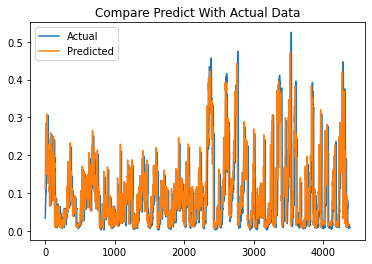

In [34]:
plt.plot(model.pm25_test, label="Actual")
plt.plot(predict, label="Predicted")
plt.legend()
plt.title("Compare Predict With Actual Data")
plt.show()

In [36]:
model.lstm_model.save('/content/drive/My Drive/trained_model/AirPollution')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/trained_model/AirPollution/assets


In [ ]:
model.cnn_model.save